In [1]:
from platform import python_version
import sklearn
import pandas as pd

print('Analysis conducted in Python', python_version())

print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The pandas version is {}.'.format(pd.__version__))


Analysis conducted in Python 3.7.1
The scikit-learn version is 0.23.2.
The pandas version is 1.0.3.


# Angiography patients

In [2]:
# import libraries
%matplotlib inline

import time
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier



plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import (confusion_matrix, accuracy_score, roc_auc_score ,roc_curve,auc, precision_recall_curve, 
f1_score, average_precision_score, auc)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_colwidth', -1)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

C:\Users\Amber\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


# read in data

In [3]:
# read data in from dat file and assign column headers based on supporting info

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_table(url, sep=",",  names=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak', 'slope',
                         'ca', 'thal', 'num'])

# create a new binary variable for the target in which 'num' > 0 is heart disease
# drop unecessary 'num' catgeory

df['target'] = 0

df.loc[(df['num'] > 0), 'target'] = 1

df.drop(columns =['num'], inplace=True)

df.shape

(303, 14)

# Cleaning step 1: expected data types

* We find that two columns expected to be numeric are objects. 
* Check the values and find ? symbol used for missing data

In [4]:
# find any non-numeric columns
non_numeric_columns = list(df.select_dtypes(include=object).columns.values)

# print value counts
for a in non_numeric_columns:
    b = df[a].value_counts()
    print(b)
    
# drop rows with missing values 
df1 = df[df['thal'] != '?'].copy()
df2 = df1[df1['ca'] != '?'].copy()

# convert those columns back to float
df2["ca"] = pd.to_numeric(df2["ca"])
df2["thal"] = pd.to_numeric(df2["thal"])

0.0    176
1.0    65 
2.0    38 
3.0    20 
?      4  
Name: ca, dtype: int64
3.0    166
7.0    117
6.0    18 
?      2  
Name: thal, dtype: int64


# Cleaning step 2: sense check min and max, blanks

* Mins and maxes of categorical variables are all within the specified bounds.
* There are no blanks.
* Quick background research and prior knowledge imply continuous fields are plausible (unsure whether cholesterol is total and BP is systolic or diastolic) - if actual research piece would need input on expected levels for verification purposes

In [5]:
# check min max

df2.describe().loc[['min','max']]

# check for blanks
blanks = df2.isna().sum()

if blanks.sum() == 0:
    print('No missing values')
else:

    for a in blanks:
        if a >0:
            print('there are blanks in {}'.format(a))
        else:
            pass

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
min,29.0,0.0,1.0,94.0,126.0,0.0,0.0,71.0,0.0,0.0,1.0,0.0,3.0,0.0
max,77.0,1.0,4.0,200.0,564.0,1.0,2.0,202.0,1.0,6.2,3.0,3.0,7.0,1.0


No missing values


# Histograms to get a better sense of the data

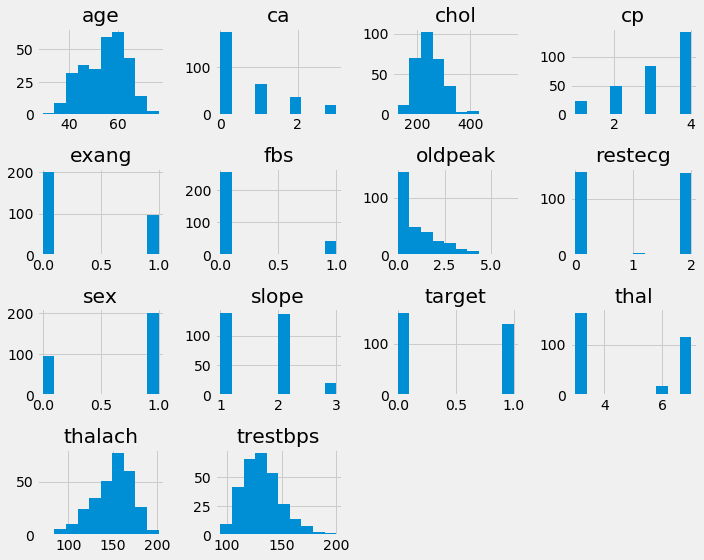

In [7]:
fig = df2.hist(figsize=(10,8), layout=(4,4))
plt.tight_layout()
plt.show()

# Target distribution to see what the class balance is

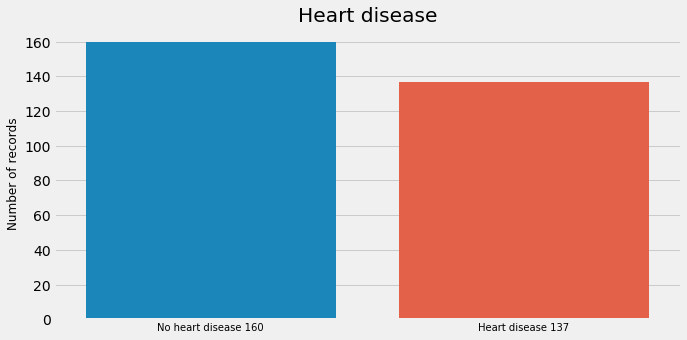

In [8]:
targets = df2['target'].value_counts()
class_names = ['No heart disease {}'.format(targets[0]), 'Heart disease {}'.format(targets[1])]

plt.figure(figsize=(10,5))
ax = sns.barplot(targets.index, targets.values, alpha=1)
plt.title('Heart disease')
plt.ylabel('Number of records', fontsize=12)
ax.set_xticklabels(class_names, rotation='horizontal', fontsize=10)

plt.show();

# Beginning feature selection with filter methods

In [9]:
# make age groups (our min age is 29 and max age is 77)

age_bins = [20, 40, 50, 60, 70, 80]

age_cats = ['20-39', '40-49', '50-59', '60-69', '70-79']

age_groups = pd.cut(df2['age'], age_bins, labels=age_cats)

df2['age_groups'] = pd.cut(df2['age'], age_bins, labels=age_cats)

## Let's look at association between categorical features and the target

- We can use chi square contingency tables to examine catgeorgical features

In [10]:
from scipy.stats import chi2_contingency 

# make lists of categorical variables for encoding vs not

encode_cat = ['age_groups','cp', 'restecg', 'slope', 'thal']
non_cat = ['sex', 'fbs',  'exang', 'ca']


# create blank list for variables to drop

drop_list = []

for i in encode_cat + non_cat :
    ct = pd.crosstab(columns=df2[i],index=df["target"])
    stat, p, dof, expected = chi2_contingency(ct)

    print(ct)
    if p < 0.05:
        print('Keep_variable for {}'.format(i))
    else:
        drop_list.append(i)
        print('Drop variable for {}'.format(i))


df2.drop(columns = drop_list, inplace=True)

age_groups  20-39  40-49  50-59  60-69  70-79
target                                       
0           11     53     61     30     5    
1           6      22     65     43     1    
Keep_variable for age_groups
cp      1.0  2.0  3.0  4.0
target                    
0       16   40   65   39 
1       7    9    18   103
Keep_variable for cp
restecg  0.0  1.0  2.0
target                
0        92   1    67 
1        55   3    79 
Keep_variable for restecg
slope   1.0  2.0  3.0
target               
0       103  48   9  
1       36   89   12 
Keep_variable for slope
thal    3.0  6.0  7.0
target               
0       127  6    27 
1       37   12   88 
Keep_variable for thal
sex     0.0  1.0
target          
0       71   89 
1       25   112
Keep_variable for sex
fbs     0.0  1.0
target          
0       137  23 
1       117  20 
Drop variable for fbs
exang   0.0  1.0
target          
0       137  23 
1       63   74 
Keep_variable for exang
ca      0.0  1.0  2.0  3.0
target            

# Now we can look at continuous variables

- we check for outliers and note that they are within acceptable bounds of plausibility
- We see that age, oldpeak and thalach seem to be associated with the target

In [11]:
# calculate summary statistics
from numpy import mean, std

# continuous variable list
var_cont = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


# create list
outlier_list = []

for i in var_cont:
    
    data_mean, data_std = mean(df2[i]), std(df2[i])
    # identify outliers
    cut_off = data_std * 3
    lower, upper = (data_mean - cut_off), (data_mean + cut_off)
    # identify outliers
    outliers = [x for x in df2[i] if (x < lower) or (x > upper)]
    outlier_list.append(outliers)
    print('Identified outliers: %d' % len(outliers))

outlier_df = pd.DataFrame()
#outlier_df

outlier_df['variable'] = var_cont
outlier_df['outliers'] = outlier_list

outlier_df

Identified outliers: 0
Identified outliers: 2
Identified outliers: 4
Identified outliers: 1
Identified outliers: 2


,variable,outliers
0,age,[]
1,trestbps,"[200.0, 192.0]"
2,chol,"[417.0, 407.0, 564.0, 409.0]"
3,thalach,[71.0]
4,oldpeak,"[6.2, 5.6]"


,age,trestbps,chol,thalach,oldpeak
target,,,,,
0,52.643750,129.175000,243.493750,158.581250,0.598750
1,56.759124,134.635036,251.854015,139.109489,1.589051


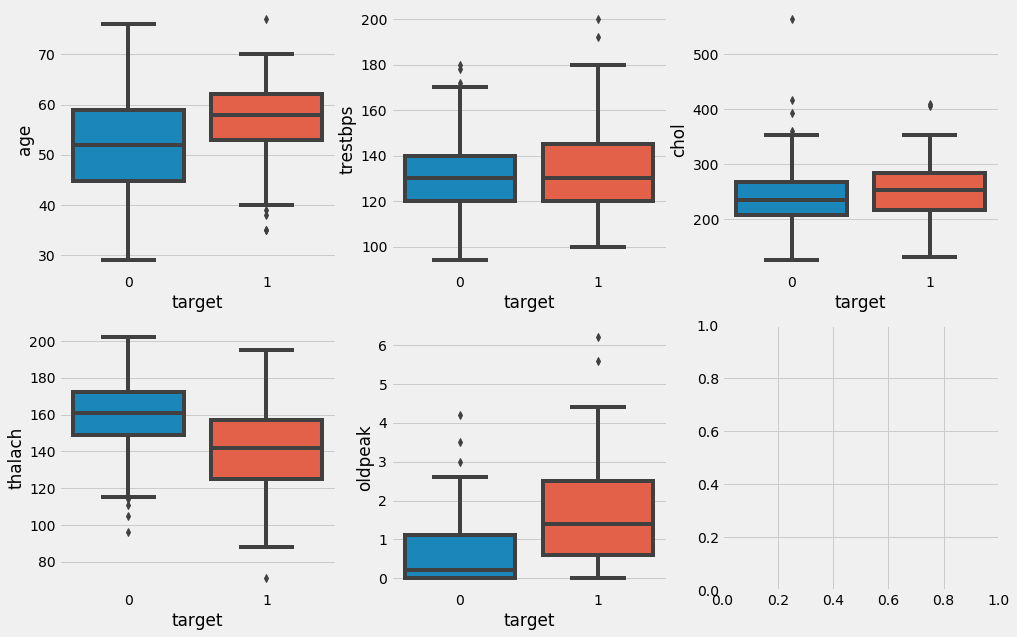

In [12]:
# continuous variables
df2[var_cont + ['target']].groupby(['target']).mean()

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for var, subplot in zip(var_cont, ax.flatten()):
    sns.boxplot(x='target', y=var, data=df2, ax=subplot)

## We can look for correlations between variables using spearman as it can be used for categorical and continuous and doesn't assume normality

- We see then that no variables are highly correlated - spearman > 0.6, although slope and oldpeak are close

,Feature 1,Feature 2,Correlation Coefficient
12,slope,oldpeak,0.577537
14,target,exang,0.431894
16,target,oldpeak,0.424510
18,thalach,target,0.417167
20,target,cp,0.414446


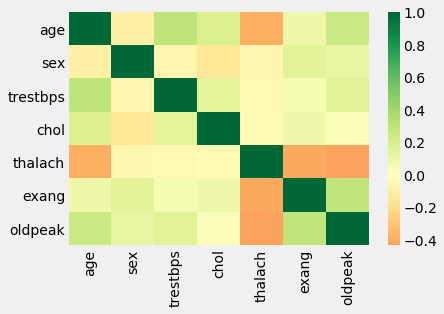

In [13]:
p = sns.heatmap(df2[['age', 'sex', 'trestbps', 'chol', 'thalach', 'exang', 'oldpeak']].corr('spearman'), center=0, cmap = 'RdYlGn')

# Training set high correlations

df_train_corr = df.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

# set threshold at 0.4 for a moderate correlation
corr = df_train_corr_nd['Correlation Coefficient'] > 0.4
df_train_corr_nd[corr]

## Model building - 3 different models

In [19]:
dummies_columns = ['age_groups','thal','slope', 'restecg', 'cp']

numerical_columns = ['trestbps', 'chol', 'thalach', 'oldpeak', 'sex', 'exang', 'ca']

X = df2.drop(columns='target')

y = df2['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)


# pipeline stuff
categorical_pipe = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# note that this is not used in this model
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, dummies_columns),
     ('num', numerical_pipe, numerical_columns)])


lr = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000))
])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced',))
])

xgb = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', XGBClassifier(random_state=42))
])

# lR params


# Create hyperparameter options

param_grid_lr = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']}
]

param_grid_rf = [

     {'classifier' : [RandomForestClassifier()],
     'classifier__criterion':['gini','entropy'],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]

param_grid_xgb = [{'classifier' : [ XGBClassifier()],
   'classifier__max_depth': range (2, 10, 1),
    'classifier__n_estimators': range(60, 220, 40),
    'classifier__learning_rate': [0.1, 0.01, 0.05]}
]

# Create grid search using 10-fold cross validation
clf_lr = GridSearchCV(lr, param_grid_lr, cv=10, verbose=0, scoring='balanced_accuracy',n_jobs= -1)
clf_rf = GridSearchCV(rf, param_grid_rf, cv=10, verbose=0, scoring='balanced_accuracy', n_jobs= -1)
clf_xgb = GridSearchCV(xgb, param_grid_xgb,cv=10, verbose=0, scoring='balanced_accuracy', n_jobs= -1 )

model_lr = clf_lr.fit(X_train, y_train)
model_rf = clf_rf.fit(X_train, y_train)
model_xgb = clf_xgb.fit(X_train, y_train)

lr.set_params(**clf_lr.best_params_).fit(X_train, y_train)
rf.set_params(**clf_rf.best_params_).fit(X_train, y_train)
xgb.set_params(**clf_xgb.best_params_).fit(X_train, y_train)

print("LR train accuracy: %0.3f" % lr.score(X_train, y_train))
print("LR test accuracy: %0.3f" % lr.score(X_test, y_test))

print("rf train accuracy: %0.3f" % rf.score(X_train, y_train))
print("rf test accuracy: %0.3f" % rf.score(X_test, y_test))

print("xgb train accuracy: %0.3f" % xgb.score(X_train, y_train))
print("xgb test accuracy: %0.3f" % xgb.score(X_test, y_test))

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_groups', 'thal',
                                                   'slope', 'restecg', 'cp']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['trestbps', 'chol',
                                                   'thalach', 'oldpeak', 'sex',
                                                   'exang', 'ca'])])),
                ('classifier',
                 LogisticRegression(C=0.08858667904100823,
                                    sol

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_groups', 'thal',
                                                   'slope', 'restecg', 'cp']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['trestbps', 'chol',
                                                   'thalach', 'oldpeak', 'sex',
                                                   'exang', 'ca'])])),
                ('classifier',
                 RandomForestClassifier(max_features=11, n_estimators=80))])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_groups', 'thal',
                                                   'slope', 'restecg', 'cp']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['trestbps', 'chol',
                                                   'thalach', 'oldpeak', 'sex',
                                                   'exang', 'ca'])])),
                ('classifier', XGBClassifier(max_depth=2))])

LR train accuracy: 0.860
LR test accuracy: 0.867
rf train accuracy: 1.000
rf test accuracy: 0.813
xgb train accuracy: 0.910
xgb test accuracy: 0.867


# Get parameters of best models

In [51]:
clf_rf.best_params_

clf_lr.best_params_

clf_xgb.best_params_

{'classifier': RandomForestClassifier(max_features=11, n_estimators=80),
 'classifier__criterion': 'gini',
 'classifier__max_features': 11,
 'classifier__n_estimators': 80}

{'classifier': LogisticRegression(C=0.08858667904100823, solver='liblinear'),
 'classifier__C': 0.08858667904100823,
 'classifier__penalty': 'l2',
 'classifier__solver': 'liblinear'}

{'classifier': XGBClassifier(max_depth=2),
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 2,
 'classifier__n_estimators': 100}

# Confusion matrix for LR

In [20]:
best_model = lr

# predict class labels for test set

predicted = best_model.predict(X_test)


# generate class probabilities

probs = best_model.predict_proba(X_test)

THRESHOLD = 0.5
preds = np.where(best_model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

print(metrics.confusion_matrix(y_test, preds))
print(metrics.classification_report(y_test, preds))
print(metrics.balanced_accuracy_score(y_test, preds))
print(metrics.roc_auc_score(y_test, probs[:, 1]))
print(metrics.f1_score(y_test, preds))


[[36  4]
 [ 6 29]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        40
           1       0.88      0.83      0.85        35

    accuracy                           0.87        75
   macro avg       0.87      0.86      0.87        75
weighted avg       0.87      0.87      0.87        75

0.8642857142857143
0.9392857142857143
0.8529411764705883


# Confusion matrix for RF

In [21]:
best_model = rf

# predict class labels for test set

predicted = best_model.predict(X_test)


# generate class probabilities

probs = best_model.predict_proba(X_test)

THRESHOLD = 0.5
preds = np.where(best_model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

print(metrics.confusion_matrix(y_test, preds))
print(metrics.classification_report(y_test, preds))
print(metrics.balanced_accuracy_score(y_test, preds))
print(metrics.roc_auc_score(y_test, probs[:, 1]))
print(metrics.f1_score(y_test, preds))


[[34  6]
 [ 8 27]]
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        40
           1       0.82      0.77      0.79        35

    accuracy                           0.81        75
   macro avg       0.81      0.81      0.81        75
weighted avg       0.81      0.81      0.81        75

0.8107142857142857
0.9128571428571429
0.7941176470588236


# Confusion matrix for XGB

In [22]:
best_model = xgb

# predict class labels for test set

predicted = best_model.predict(X_test)


# generate class probabilities

probs = best_model.predict_proba(X_test)

THRESHOLD = 0.5
preds = np.where(best_model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

print(metrics.confusion_matrix(y_test, preds))
print(metrics.classification_report(y_test, preds))
print(metrics.balanced_accuracy_score(y_test, preds))
print(metrics.roc_auc_score(y_test, probs[:, 1]))
print(metrics.f1_score(y_test, preds))


[[35  5]
 [ 5 30]]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        40
           1       0.86      0.86      0.86        35

    accuracy                           0.87        75
   macro avg       0.87      0.87      0.87        75
weighted avg       0.87      0.87      0.87        75

0.8660714285714286
0.9235714285714286
0.8571428571428571


## Permutation importance for logistic regression

ca      0.065 +/- 0.020
thal    0.053 +/- 0.015


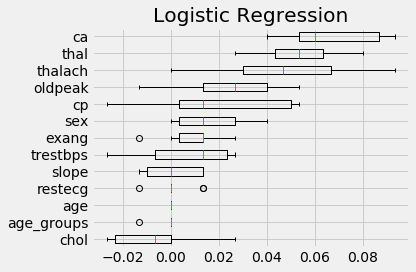

In [23]:
from sklearn.inspection import permutation_importance

r = permutation_importance(lr, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = r.importances_mean.argsort()

for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
             print(f"{X_test.columns[i]:<8}"
                   f"{r.importances_mean[i]:.3f}"
                   f" +/- {r.importances_std[i]:.3f}")
fig, ax = plt.subplots()
ax.boxplot(r.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Logistic Regression")
fig.tight_layout()
plt.show();

## Permutation importance for XGBoost

ca      0.067 +/- 0.020
thal    0.060 +/- 0.016
oldpeak 0.057 +/- 0.027
sex     0.019 +/- 0.009


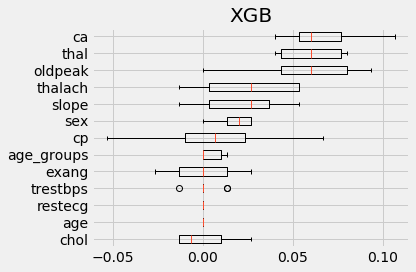

In [24]:
from sklearn.inspection import permutation_importance

r = permutation_importance(xgb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = r.importances_mean.argsort()

for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
             print(f"{X_test.columns[i]:<8}"
                   f"{r.importances_mean[i]:.3f}"
                   f" +/- {r.importances_std[i]:.3f}")
fig, ax = plt.subplots()
ax.boxplot(r.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("XGB")
fig.tight_layout()
plt.show();

## Permutation importance for Random Forest

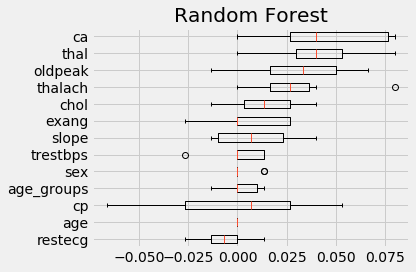

In [25]:
from sklearn.inspection import permutation_importance

r = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = r.importances_mean.argsort()

for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
             print(f"{X_test.columns[i]:<8}"
                   f"{r.importances_mean[i]:.3f}"
                   f" +/- {r.importances_std[i]:.3f}")
fig, ax = plt.subplots()
ax.boxplot(r.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Random Forest")
fig.tight_layout()
plt.show();